In [2]:
import sys
sys.path.append('/home/tcalo3/projects/project6')
sys.path.append('/home/tcalo3/projects/project6/src/modules/components/ganspace')

In [3]:
# Load model
from IPython.utils import io
import ipywidgets as widgets
from PIL import Image
import imageio
from models import get_instrumented_model
from decomposition import get_or_compute
from config import Config
from skimage import img_as_ubyte
from PIL import Image
import numpy as np
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.monte_carlo import qUpperConfidenceBound
import warnings
import numpy as np
import math
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.models.pairwise_gp import PairwiseGP, PairwiseLaplaceMarginalLogLikelihood

warnings.filterwarnings('ignore')

# Speed up computation
torch.autograd.set_grad_enabled(False)
torch.backends.cudnn.benchmark = True

# Specify model to use
config = Config(
  model='StyleGAN',
  layer='g_mapping.dense7',
  output_class='ffhq',
  components=32,
  use_w=True,
  batch_size=5_000, # style layer quite small
)

inst = get_instrumented_model(config.model, config.output_class,
                              config.layer, torch.device('cuda'), use_w=config.use_w)

path_to_components = get_or_compute(config, inst)

model = inst.model

StyleGAN2: Optimized CUDA op FusedLeakyReLU not available, using native PyTorch fallback.
StyleGAN2: Optimized CUDA op UpFirDn2d not available, using native PyTorch fallback.


In [13]:
from src.modules.metrics.models.facenet import FaceNetModel

def sample_pca_space(n_samples, pca_components, pca_stdevs):
    random_samples = np.random.randn(n_samples, pca_components) * pca_stdevs
    return random_samples

def reconstruct_from_pca(pca_samples, pca_components, data_mean):
    original_data = np.dot(pca_samples, pca_components) + data_mean
    return original_data


def project_to_pca(new_data, pca_components, data_mean):
    centered_data = new_data - data_mean
    pca_projection = np.dot(centered_data, pca_components.T)
    return pca_projection

with torch.set_grad_enabled(False):
    facenet = FaceNetModel().eval()
    pass




In [15]:
# Generate the images
y_latent = model.sample_latent(1).cpu().detach().numpy() 
y_gan =  model.sample_np(y_latent.astype(np.float32))
y_image = Image.fromarray((y_gan * 255).astype(np.uint8))


In [25]:
y_gan.shape

(1024, 1024, 3)

In [46]:
from facenet_pytorch import MTCNN, InceptionResnetV1

# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=512)
# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval()

In [47]:
# Get cropped and prewhitened image tensor
img_cropped = mtcnn(y_image)
# Calculate embedding (unsqueeze to add batch dimension)
img_embedding = resnet(img_cropped.unsqueeze(0))
# Or, if using for VGGFace2 classification
resnet.classify = True
img_probs = resnet(img_cropped.unsqueeze(0))

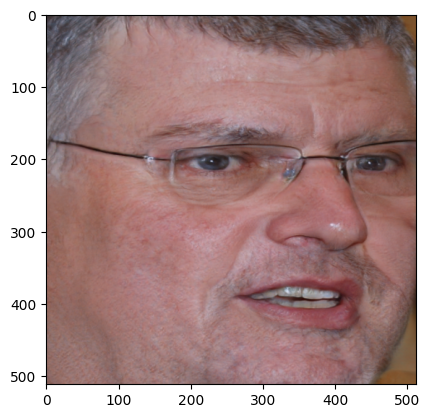

In [61]:
# Rearrange it to [Height, Width, Channels]
img_normalized = (img_cropped + 1) / 2
img_to_display = (img_normalized).permute(1, 2, 0)
# Display the image
plt.imshow(img_to_display)


In [78]:
# Utility function to manage hooks
def register_hooks(eval_model):
    features = {}
    layers = {
    'conv2d_2b': eval_model.resnet.conv2d_2b,
    'repeat_1_block0': eval_model.resnet.repeat_1[0],
    'mixed_6a': eval_model.resnet.mixed_6a,
    'conv2d_4a': eval_model.resnet.conv2d_4a,
    'conv2d_4b': eval_model.resnet.conv2d_4b,
    'repeat_2_block0': eval_model.resnet.repeat_2[0],
    'repeat_3_block0': eval_model.resnet.repeat_3[0],
    'mixed_7a': eval_model.resnet.mixed_7a,
    'block8': eval_model.resnet.block8,
    'last_linear': eval_model.resnet.last_linear
}

# Example usage, accessing the first block of the repeat_1 layers:

    
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.flatten(start_dim=1)
        return hook

    hooks = []
    for name, layer in layers.items():
        hook = layer.register_forward_hook(get_features(name))
        hooks.append(hook)
    return features, hooks

def clear_hooks(hooks):
    for hook in hooks:
        hook.remove()

In [79]:
def reconstruct_and_evaluate(x, target, model, latent_dirs, data_mean):
    target_out = model.sample_np(target)
    target_image = Image.fromarray((target_out * 255).astype(np.uint8))
    target_resized_image = target_image.resize((160, 160), Image.NEAREST)
    target_tensor = torch.from_numpy(np.array(target_resized_image)).unsqueeze(0).permute(0, 3, 1, 2).float()

    x_reconstructed = reconstruct_from_pca(x,latent_dirs,data_mean)
    x_gan = model.sample_np(x_reconstructed.astype(np.float32))
    x_image = Image.fromarray((x_gan * 255).astype(np.uint8))
    x_resized_image = x_image.resize((160, 160), Image.NEAREST)
    x_tensor = torch.from_numpy(np.array(x_resized_image)).unsqueeze(0).permute(0, 3, 1, 2).float()
    


    features, hooks = register_hooks(facenet)

    try:
        _ = facenet(target_tensor)  # Process target image
        target_features = [features[layer] for layer in features.keys()]
        target_features_concat = torch.cat(target_features, dim=1)

        features.clear()  # Clear features for next input
        _ = facenet(x_tensor)  # Process input image
        input_features = [features[layer] for layer in features.keys()]
        input_features_concat = torch.cat(input_features, dim=1)

    finally:
        clear_hooks(hooks) 
    similarity = torch.nn.functional.cosine_similarity(target_features_concat, input_features_concat, dim=1)


    return similarity

In [83]:
def reconstruct_and_evaluate(x, target, model, latent_dirs, data_mean):
    target_out = model.sample_np(target)
    target_image = Image.fromarray((target_out * 255).astype(np.uint8))

    x_reconstructed = reconstruct_from_pca(x,latent_dirs,data_mean)
    x_gan = model.sample_np(x_reconstructed.astype(np.float32))
    x_image = Image.fromarray((x_gan * 255).astype(np.uint8))

    # Get cropped and prewhitened image tensor
    target_image_cropped = mtcnn(target_image)
    x_image_cropped = mtcnn(x_image)

    # Calculate embedding (unsqueeze to add batch dimension)
    resnet.classify = True

    target_image_embedding = resnet(target_image_cropped.unsqueeze(0))
    x_image_embedding = resnet(x_image_cropped.unsqueeze(0))


    similarity = torch.nn.functional.cosine_similarity(target_image_embedding, x_image_embedding, dim=1)


    return similarity

In [80]:
#@title Load a component at random
path_to_components="/home/tcalo3/projects/project6/src/modules/components/ganspace/cache/components/stylegan-ffhq_g_mapping.dense7_pca-full_c16_n300000_w.npz"
comps = np.load(path_to_components)

latent_dirs = comps['lat_comp'][:,0,:]
latent_stdevs = comps['lat_stdev']
data_mean = comps['lat_mean']

#load one at random
dims = latent_stdevs.shape[0]
num = np.random.randint(dims)
random_dir = latent_dirs[num]
random_dir_stdev = latent_stdevs[num]
print(f'Loaded Component No. {num}')

# Define the bounds of your optimization based on PCA variances (assuming normality and using some scale factor)
bounds = torch.stack([
    torch.tensor([-1 * stdev for stdev in latent_stdevs]),  # Lower bounds
    torch.tensor([1 * stdev for stdev in latent_stdevs])   # Upper bounds
]).double()




Loaded Component No. 8


In [81]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood

def optimize(train_x, train_y, target, best_similarity, bounds):
        # Create fixed bounds where only the selected dimension can vary
    lower_bounds, upper_bounds = bounds[0, :], bounds[1, :]
    fixed_bounds = torch.stack([lower_bounds, upper_bounds], dim=-1)

    with torch.enable_grad():
        gp_model = SingleTaskGP(train_x, train_y)
        mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
        fit_gpytorch_model(mll)
            
        EI = ExpectedImprovement(model=gp_model, best_f=train_y.max())
        # Optimize using the acquisition function
        candidate, _ = optimize_acqf(
            acq_function=EI,
            bounds=fixed_bounds.T,
            q=1,
            num_restarts=10,
            raw_samples=512,
        )

    candidate_similarity = reconstruct_and_evaluate(candidate, target, model, latent_dirs, data_mean)
    reward = 1 if candidate_similarity > best_similarity else 0
    best_similarity = candidate_similarity if candidate_similarity > best_similarity else best_similarity
    new_reward = torch.tensor([reward]).unsqueeze(-1).double()
    new_train_x = torch.cat([train_x, candidate], dim=0)
    new_train_y = torch.cat([train_y, new_reward], dim=0)

    return new_train_x, new_train_y, reward, best_similarity



In [84]:
num_arms = dims
max_steps = 1000

target = model.sample_latent(1).cpu().detach().numpy() 
x_0 = sample_pca_space(1,dims,latent_stdevs)
best_similarity = reconstruct_and_evaluate(x_0, target, model, latent_dirs, data_mean)

train_x = sample_pca_space(1,dims,latent_stdevs)
similarity = reconstruct_and_evaluate(train_x, target, model, latent_dirs, data_mean)
reward = 1 if similarity > best_similarity else 0

# Create a GP model from the existing data
train_x = torch.from_numpy(train_x).double()
train_y = torch.tensor([reward]).unsqueeze(-1).double()

# Running the bandit algorithm
for step in range(1, max_steps):
    train_x, train_y, reward, best_similarity = optimize(train_x, train_y, target, best_similarity, bounds)
    print(step,best_similarity)
    

1 tensor([0.8418])
2 tensor([0.8418])
3 tensor([0.8418])
4 tensor([0.8418])
5 tensor([0.8418])
6 tensor([0.8418])
7 tensor([0.8418])
8 tensor([0.8418])
9 tensor([0.8424])
10 tensor([0.8424])
11 tensor([0.8424])
12 tensor([0.9066])
13 tensor([0.9166])
14 tensor([0.9166])
15 tensor([0.9166])
16 tensor([0.9310])
17 tensor([0.9310])
18 tensor([0.9310])
19 tensor([0.9310])
20 tensor([0.9310])
21 tensor([0.9310])
22 tensor([0.9310])
23 tensor([0.9310])
24 tensor([0.9310])
25 tensor([0.9310])
26 tensor([0.9386])
27 tensor([0.9386])
28 tensor([0.9386])
29 tensor([0.9386])
30 tensor([0.9386])
31 tensor([0.9386])
32 tensor([0.9386])
33 tensor([0.9386])
34 tensor([0.9386])
35 tensor([0.9386])
36 tensor([0.9386])
37 tensor([0.9386])
38 tensor([0.9386])
39 tensor([0.9386])
40 tensor([0.9386])
41 tensor([0.9386])
42 tensor([0.9386])
43 tensor([0.9386])
44 tensor([0.9386])
45 tensor([0.9386])
46 tensor([0.9386])
47 tensor([0.9386])
48 tensor([0.9386])
49 tensor([0.9386])
50 tensor([0.9386])
51 tensor

KeyboardInterrupt: 

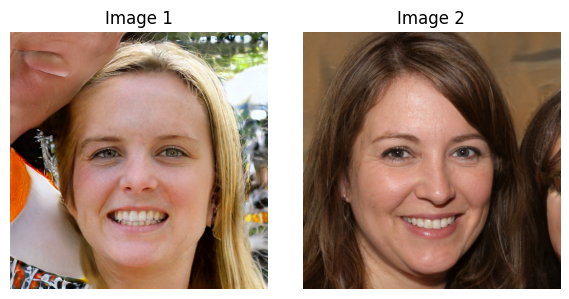

In [85]:
import matplotlib.pyplot as plt

# Generate the images
y_gan =  model.sample_np(target.astype(np.float32))
y_image = Image.fromarray((y_gan * 255).astype(np.uint8))


x_reconstructed = reconstruct_from_pca(train_x[-1],latent_dirs,data_mean)
x_gan = model.sample_np(x_reconstructed.astype(np.float32))
x_image = Image.fromarray((x_gan * 255).astype(np.uint8))

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

# Display the first image in the left subplot
ax1.imshow(y_image)
ax1.set_title('Image 1')
ax1.axis('off')

# Display the second image in the right subplot
ax2.imshow(x_image)
ax2.set_title('Image 2')
ax2.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [23]:
def get_tensors(x, target, model, latent_dirs, data_mean):
    target_out = model.sample_np(target)
    target_image = Image.fromarray((target_out * 255).astype(np.uint8))
    target_resized_image = target_image.resize((160, 160), Image.NEAREST)
    target_tensor = torch.from_numpy(np.array(target_resized_image)).unsqueeze(0).permute(0, 3, 1, 2)

    x_reconstructed = reconstruct_from_pca(x,latent_dirs,data_mean)
    x_gan = model.sample_np(x_reconstructed.astype(np.float32))
    x_image = Image.fromarray((x_gan * 255).astype(np.uint8))
    x_resized_image = x_image.resize((160, 160), Image.NEAREST)
    x_tensor = torch.from_numpy(np.array(x_resized_image)).unsqueeze(0).permute(0, 3, 1, 2)

    return x_tensor.float(),target_tensor.float()



